In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pymc

sys.path.append(f'{os.path.dirname(os.path.dirname(os.getcwd()))}/draft_pick_prob')

In [65]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv')
draft_df = pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv', encoding='ISO-8859-1')


mock_draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_SW_jun22_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_SW_21'})
mock_draft_df_2=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PW_jun21_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_PW_21'})
mock_draft_df_3=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_CP_jun15_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP_21'})
mock_draft_df_4=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_CP_md.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_2CP_21'})


possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv',encoding='ISO-8859-1')
possible_players

,PLAYER_NAME,PLAYER_ID
0,Owen Power,1
1,Matty Beniers,2
2,Mason McTavish,3
3,Luke Hughes,4
4,Kent Johnson,5
...,...,...
255,Jeremy Wilmer,255
256,Trevor Wong,256
257,Kalle Ervasti,257
258,Luke Mittelstadt,258


In [66]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv',encoding='ISO-8859-1')

file_list =['2021_SW_jun22_bb.csv','2021_PW_jun21_bb.csv','2021_CP_jun15_bb.csv','2021_CP_md.csv']

mock_draft_dfs = []


for filename in file_list:
    df = pd.read_csv(filename)  # Read the CSV file
    
    # Sort the DataFrame by 'RANK' column
    df = df.sort_values(by='RANK')
    
    #section not needed for 2021 because it is already all consecutive
    # Check if 'RANK' increases by 1 each time
    #is_consecutive = df['RANK'].diff() == 1
    
    # Use a mask to filter the DataFrame to keep only consecutive ranks
    #df = df[is_consecutive]
    
    prefix = filename[5:7]
        
    # Rename the 'RANK' column based on the extracted prefix
    if filename[-6:-4]== 'bb':
        df = df.rename(columns={'RANK': f'bb_RANK_{prefix}_21'})
    else:
        df = df.rename(columns={'RANK': f'md_RANK_{prefix}_21'})
    
    mock_draft_dfs.append(df)  # Add the processed DataFrame to the list



#possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv')
#draft_df
#possible_players



In [68]:
import math
df_player_rankings=possible_players[['PLAYER_ID']].merge(mock_draft_dfs[0][['PLAYER_ID','bb_RANK_SW_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[1][['PLAYER_ID','bb_RANK_PW_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[2][['PLAYER_ID','bb_RANK_CP_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[3][['PLAYER_ID','md_RANK_CP_21']], how='left', on=['PLAYER_ID'])



df_player_rankings


,PLAYER_ID,bb_RANK_SW_21,bb_RANK_PW_21,bb_RANK_CP_21,md_RANK_CP_21
0,1,1.0,1.0,1.0,1.0
1,2,4.0,2.0,5.0,2.0
2,3,10.0,7.0,9.0,6.0
3,4,7.0,6.0,4.0,4.0
4,5,2.0,9.0,6.0,9.0
...,...,...,...,...,...
255,255,73.0,NaN,NaN,NaN
256,256,81.0,NaN,NaN,NaN
257,257,87.0,NaN,NaN,NaN
258,258,97.0,NaN,NaN,NaN


In [75]:
def likelihood(strengths, rankings):
    # params: vector of parameters [intercept, slope]
    likelihood=1
    counter=1
    paired_lists = list(zip(strengths, rankings))
    sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    while counter<len(sorted_list2)+1 and sorted_list2[counter]!=sorted_list2[counter+1]:
        # print(np.exp(sorted_list1[counter-1]))
        # print(np.sum(np.exp(sorted_list1[counter-1:])))
        # print(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        likelihood+=np.log(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        counter+=1
    return likelihood

def neg_log_likelihood(params, df):
    neg_ll = 1  # Initialize as 0 for correct accumulation
    columns_to_go_through = df.columns[1:]
    for i in columns_to_go_through:
        max_rank = df[i].max() + 1
        player_rank = list(df[i])
        fixed_player_rank = [max_rank if math.isnan(x) else x for x in player_rank]
        
        # Determine the weighting factor based on column name
        if i.startswith('bb'):
            weight = 1  # Example: 0.5 for less value
        elif i.startswith('md'):
            weight = 1.0  # Example: 1.0 (or more) for 'md' columns
        else:
            weight = 1.0  # Default weight for other columns

        # Apply the weighting factor
        neg_ll -= weight * likelihood(params, fixed_player_rank)

    return neg_ll

In [70]:
def constraint_eq(x):
    return sum(x)

In [76]:
import scipy.optimize

counter=40
l_play=[]
variable_bounds=[]
count=0

while count<len(df_player_rankings):
    l_play.append(counter)
    count+=1
    counter-=0.20
    variable_bounds.append((-40,40))

result = scipy.optimize.minimize(neg_log_likelihood, l_play, args=(df_player_rankings,), method='SLSQP', bounds=variable_bounds, constraints={'type': 'eq', 'fun': constraint_eq})
print(result.x)

[ 39.39428629  28.01464158  25.2704103   26.86048464  25.59351465
  24.40711292  27.18332125  26.28411274  27.50650898  16.21766128
  22.55482645  21.62214144  19.31604908  22.00423789  20.85642972
  18.89734462  23.2881096   19.44811714  23.83511237  20.66575365
  19.86547846  17.15983922  17.79407399  20.47374947  21.39339467
  18.21390865  19.80434051  15.59890551  17.88395569 -25.493523
  13.41648286  17.04363815  17.50464715  -1.30296019  14.86678484
   1.17714021  17.94076201   1.9123882   14.06254053  14.92534555
  18.23077154  13.80030327  15.78991738  15.48328975  18.56435128
  18.97870363  14.24023269   1.64333629  20.18853665  15.63105263
  20.92017788  16.67852442  16.65871907  13.03749592  15.96108136
  15.58742421  14.42675665  15.06230565   1.5186927   16.91095906
  14.52686951  15.32282135  14.35129749   1.50613567  18.71544551
  14.58492466  17.56738849  17.04435727   1.72932543  17.23996452
  15.95192025  15.56013821   0.94788377  15.18192802  -0.73143908
  13.0966756

In [77]:
player_ability_parameters_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv', encoding='ISO-8859-1')
player_ability_parameters_df['ABILITY_PARAMS']=result.x
player_ability_parameters_df=player_ability_parameters_df.sort_values(by='ABILITY_PARAMS', ascending=False, axis=0)
player_ability_parameters_df['SIM_RANK'] = range(1, len(player_ability_parameters_df) + 1)
player_ability_parameters_df.head(10)


,PLAYER_NAME,PLAYER_ID,ABILITY_PARAMS,SIM_RANK
0,Owen Power,1,39.394286,1
1,Matty Beniers,2,28.014642,2
8,Dylan Guenther,9,27.506509,3
6,William Eklund,7,27.183321,4
3,Luke Hughes,4,26.860485,5
7,Brandt Clarke,8,26.284113,6
4,Kent Johnson,5,25.593515,7
2,Mason McTavish,3,25.270410,8
5,Simon Edvinsson,6,24.407113,9
18,Jesper Wallstedt,20,23.835112,10


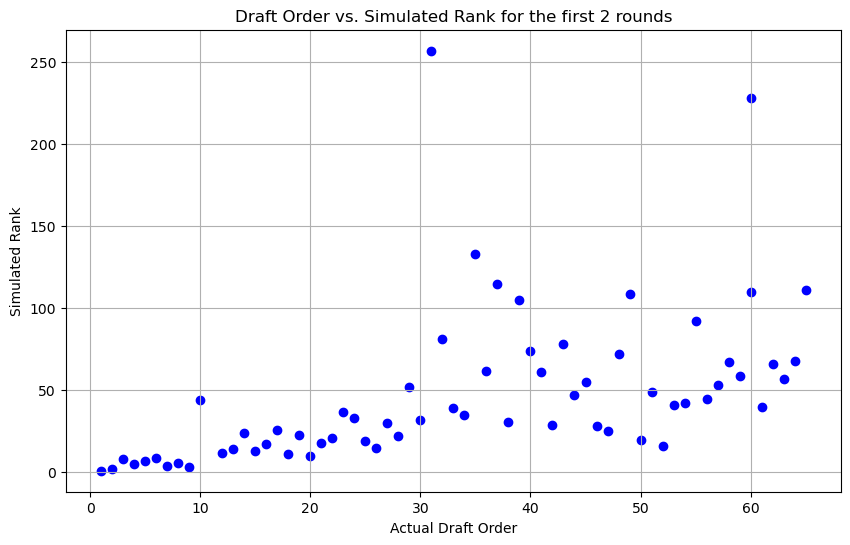

In [78]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')
merged_df
# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)


plt.show()



In [79]:
#Error -Mean absolute error (MAE)
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_NAME', 'ORDER']], on='PLAYER_NAME')
merged_df = merged_df.sort_values(by='ORDER')
merged_df = merged_df.head(32)
merged_df['ERROR'] = abs(merged_df['SIM_RANK']-merged_df['ORDER'])
mae = merged_df['ERROR'].sum()/len(merged_df['ERROR'])
print(mae)


# (-40,40 bounds gives 12.46 mae with .8 for bb and 1 for md)
# (-40,40 bounds gives 14.06 mae with 1 for bb and 1 for md)



14.0625
